# BLS


In [1]:
# BLS_config.py

from dataclasses import dataclass
from typing import Optional   # <-- add this for Python 3.9


@dataclass
class BLSConfig:
    n_feature_groups: int = 10
    feature_group_size: int = 10
    n_enhancement_groups: int = 10
    enhancement_group_size: int = 10
    feature_activation: str = "relu"          # identity, tanh, sigmoid, relu
    enhancement_activation: str = "relu"      # identity, tanh, sigmoid, relu
    lambda_reg: float = 1e-2
    add_bias: bool = True
    standardize: bool = True
    random_state: Optional[int] = 42          # <-- changed

In [2]:
# BLS.py

import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.extmath import softmax


_ACTS = {
    "identity": lambda x: x,
    "tanh": np.tanh,
    "sigmoid": lambda x: 1.0 / (1.0 + np.exp(-x)),
    "relu": lambda x: np.maximum(0.0, x),
}


class BroadLearningSystem:
    """
    Broad Learning System that uses scikit-learn:
      - StandardScaler
      - OneHotEncoder
      - Ridge for closed-form output weights
      - train_test_split helper
    """

    def __init__(self, cfg: BLSConfig):
        """
        Initialize the Broad Learning System.

        Args:
            cfg (BLSConfig): Configuration object containing all hyperparameters
                for the BLS model including feature groups, enhancement groups,
                activation functions, and regularization parameters.
        """
        self.cfg = cfg
        self.rng = np.random.default_rng(cfg.random_state)
        self.scaler = StandardScaler(
            with_mean=True, with_std=True) if cfg.standardize else None
        self.enc = None
        self.is_classification = None
        self.classes_ = None

        self.Wf, self.bf = [], []
        self.We, self.be = [], []
        self.Wout = None
        self.ridge = None

        if cfg.feature_activation not in _ACTS or cfg.enhancement_activation not in _ACTS:
            raise ValueError("Unknown activation name.")
        self.act_f = _ACTS[cfg.feature_activation]
        self.act_e = _ACTS[cfg.enhancement_activation]

    @staticmethod
    def split(X, y, test_size=0.2, random_state=0, stratify=None):
        """
        Split arrays or matrices into random train and test subsets.

        This is a convenience wrapper around sklearn's train_test_split.

        Args:
            X (array-like): Features array of shape (n_samples, n_features).
            y (array-like): Target array of shape (n_samples,) or (n_samples, n_outputs).
            test_size (float, optional): Proportion of dataset to include in test split. 
                Defaults to 0.2.
            random_state (int, optional): Random seed for reproducible splits. 
                Defaults to 0.
            stratify (array-like, optional): If not None, data is split in a stratified 
                fashion using this as class labels. Defaults to None.

        Returns:
            tuple: X_train, X_test, y_train, y_test arrays.
        """
        return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=stratify)

    # ---------- internal ----------
    def _init_groups(self, in_dim):
        """
        Initialize feature and enhancement groups with random weights and biases.

        Creates random weight matrices and bias vectors for both feature mapping
        groups and enhancement groups. Feature groups map input to feature space,
        while enhancement groups map feature outputs to enhancement space.

        Args:
            in_dim (int): Input dimension for feature groups.
        """
        self.Wf, self.bf = [], []
        for _ in range(self.cfg.n_feature_groups):
            W = self.rng.normal(0.0, 1.0, size=(
                in_dim, self.cfg.feature_group_size))
            b = self.rng.normal(0.0, 0.1, size=(self.cfg.feature_group_size,))
            self.Wf.append(W)
            self.bf.append(b)

        total_feature_nodes = self.cfg.n_feature_groups * self.cfg.feature_group_size
        self.We, self.be = [], []
        for _ in range(self.cfg.n_enhancement_groups):
            W = self.rng.normal(0.0, 1.0, size=(
                total_feature_nodes, self.cfg.enhancement_group_size))
            b = self.rng.normal(0.0, 0.1, size=(
                self.cfg.enhancement_group_size,))
            self.We.append(W)
            self.be.append(b)

    def _map_features(self, X):
        """
        Map input data through feature groups using random weights and activation functions.

        Args:
            X (np.ndarray): Input data of shape (n_samples, n_features).

        Returns:
            np.ndarray: Feature mappings of shape (n_samples, n_feature_groups * feature_group_size).
        """
        feats = [self.act_f(X @ W + b) for W, b in zip(self.Wf, self.bf)]
        return np.concatenate(feats, axis=1) if feats else np.empty((X.shape[0], 0))

    def _map_enhancements(self, F):
        """
        Map feature outputs through enhancement groups using random weights and activation functions.

        Args:
            F (np.ndarray): Feature mappings of shape (n_samples, n_feature_nodes).

        Returns:
            np.ndarray: Enhancement mappings of shape (n_samples, n_enhancement_groups * enhancement_group_size).
        """
        enh = [self.act_e(F @ W + b) for W, b in zip(self.We, self.be)]
        return np.concatenate(enh, axis=1) if enh else np.empty((F.shape[0], 0))

    def _design(self, X):
        """
        Create the design matrix by concatenating feature and enhancement mappings.

        Applies feature mapping, enhancement mapping, and optionally adds bias term
        to create the final design matrix used for output weight learning.

        Args:
            X (np.ndarray): Input data of shape (n_samples, n_features).

        Returns:
            np.ndarray: Design matrix of shape (n_samples, total_nodes + bias).
        """
        F = self._map_features(X)
        E = self._map_enhancements(F)
        H = np.concatenate([F, E], axis=1) if E.size else F
        if self.cfg.add_bias:
            H = np.concatenate([H, np.ones((H.shape[0], 1))], axis=1)
        return H

    def fit(self, X, y):
        """
        Train the Broad Learning System on the given data.

        Fits the model by standardizing input, initializing random groups,
        preparing target encoding (for classification), creating design matrix,
        and solving for optimal output weights using Ridge regression.

        Args:
            X (array-like): Training features of shape (n_samples, n_features).
            y (array-like): Training targets of shape (n_samples,) or (n_samples, n_outputs).

        Returns:
            BroadLearningSystem: Returns self for method chaining.
        """
        X = np.asarray(X, dtype=float)

        if self.scaler:
            Xs = self.scaler.fit_transform(X)
        else:
            Xs = X

        self._init_groups(Xs.shape[1])

        y = np.asarray(y)
        if y.ndim == 1 or (y.ndim == 2 and y.shape[1] == 1):
            self.is_classification = False
            T = y.astype(float)
        else:
            self.is_classification = False
            T = y.astype(float)

        H = self._design(Xs)
        self.ridge = Ridge(alpha=self.cfg.lambda_reg,
                           fit_intercept=False, random_state=self.cfg.random_state)
        self.ridge.fit(H, T)
        self.Wout = self.ridge.coef_.T
        return self

    def _forward(self, X):
        """
        Perform forward pass through the trained BLS model.

        Args:
            X (np.ndarray): Input data of shape (n_samples, n_features).

        Returns:
            np.ndarray: Model outputs of shape (n_samples, n_outputs).
        """
        if self.scaler:
            X = self.scaler.transform(X)
        H = self._design(X)
        return H @ self.Wout

    def predict(self, X):
        """
        Make predictions on new data.

        For classification tasks, returns predicted class labels.
        For regression tasks, returns predicted continuous values.

        Args:
            X (array-like): Input features of shape (n_samples, n_features).

        Returns:
            np.ndarray: Predictions of shape (n_samples,) for classification or 
                       (n_samples, n_outputs) for regression.
        """
        X = np.asarray(X, dtype=float)
        Y = self._forward(X)
        if self.is_classification:
            idx = np.argmax(Y, axis=1)
            return self.classes_[idx]
        return Y

    def predict_proba(self, X):
        """
        Compute class probabilities for input samples.

        Only available for classification tasks. Uses softmax to convert
        logits to probability distributions.

        Args:
            X (array-like): Input features of shape (n_samples, n_features).

        Returns:
            np.ndarray: Class probabilities of shape (n_samples, n_classes).

        Raises:
            ValueError: If called on a regression model.
        """
        if not self.is_classification:
            raise ValueError("predict_proba only for classification.")
        X = np.asarray(X, dtype=float)
        logits = self._forward(X)
        return softmax(logits)

    def add_feature_groups(self, k):
        """
        Add additional feature groups to expand the network breadth.

        This method supports incremental learning by adding new feature mapping
        groups without retraining the entire model. The output weights will need
        to be refitted after expansion.

        Args:
            k (int): Number of feature groups to add.

        Raises:
            RuntimeError: If called before the model is fitted.
        """
        in_dim = self.scaler.mean_.shape[0] if self.scaler else None
        if in_dim is None:
            raise RuntimeError("Model must be fitted before adding groups.")
        for _ in range(k):
            W = self.rng.normal(0.0, 1.0, size=(
                in_dim, self.cfg.feature_group_size))
            b = self.rng.normal(0.0, 0.1, size=(self.cfg.feature_group_size,))
            self.Wf.append(W)
            self.bf.append(b)

    def add_enhancement_groups(self, k):
        """
        Add additional enhancement groups to expand the network breadth.

        This method supports incremental learning by adding new enhancement
        groups that operate on the current feature space. The output weights
        will need to be refitted after expansion.

        Args:
            k (int): Number of enhancement groups to add.
        """
        total_feature_nodes = len(self.Wf) * self.cfg.feature_group_size
        for _ in range(k):
            W = self.rng.normal(0.0, 1.0, size=(
                total_feature_nodes, self.cfg.enhancement_group_size))
            b = self.rng.normal(0.0, 0.1, size=(
                self.cfg.enhancement_group_size,))
            self.We.append(W)
            self.be.append(b)

    def refit_output(self, X, y):
        """
        Refit only the output weights using the current network architecture.

        This method is efficient for updating the model after adding new feature
        or enhancement groups, as it only recomputes the final Ridge regression
        without reinitializing the random groups.

        Args:
            X (array-like): Training features of shape (n_samples, n_features).
            y (array-like): Training targets of shape (n_samples,) or (n_samples, n_outputs).

        Returns:
            BroadLearningSystem: Returns self for method chaining.
        """
        X = np.asarray(X, dtype=float)
        if self.scaler:
            X = self.scaler.transform(X)

        y = np.asarray(y)
        if self.is_classification:
            T = self.enc.transform(y.reshape(-1, 1))
        else:
            T = y.astype(float)

        H = self._design(X)
        self.ridge.fit(H, T)
        self.Wout = self.ridge.coef_.T
        return self

    def extract_features(self, X):
        """
        Extract the intermediate feature representation from the BLS network.

        Returns the design matrix (concatenated feature and enhancement mappings)
        without applying the final output weights. Useful for feature extraction
        and as input to other models like LSTMs.

        Args:
            X (array-like): Input features of shape (n_samples, n_features).

        Returns:
            np.ndarray: Feature representation of shape (n_samples, total_nodes + bias).
        """
        X = np.asarray(X, dtype=float)
        if self.scaler:
            X = self.scaler.transform(X)
        return self._design(X)

# Dataset


In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# ---------- collate ----------


def collate_keep_meta(batch):
    x = torch.stack([b["x_hist"] for b in batch])      # [B, L, F]
    y = torch.stack([b["y_future"] for b in batch])    # [B, H]
    lat = torch.tensor([b["lat"] for b in batch], dtype=torch.float32)
    lon = torch.tensor([b["lon"] for b in batch], dtype=torch.float32)
    meta = {
        "tile_id":   [b["tile_id"] for b in batch],
        "start_time": [str(b["start_time"]) for b in batch],
        "lat": lat, "lon": lon,
    }
    return {"x_hist": x, "y_future": y, "meta": meta}


# ---------- 1) Identify feature columns ----------
NON_FEATURE_COLS = {
    "lon", "lat", "time", "source_file", "PM25_MERRA2", "PM25_ug_m3", "class"
}


def get_feature_cols(df: pd.DataFrame):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feat_cols = [c for c in num_cols if c not in NON_FEATURE_COLS and c.lower() not in {
        "timestamp"}]
    return feat_cols

# ---------- 2) Parse/tidy WITHOUT resampling/filling ----------


def prepare_dataframe_noresample(df: pd.DataFrame, dayfirst=True) -> pd.DataFrame:
    """
    - Parse df['time'] -> 'timestamp'
    - Build 'tile_id'
    - Keep only numeric features + target + coords + timestamp
    - No resampling, no filling. Leave raw granularity intact.
    """
    df = df.copy()
    df["timestamp"] = pd.to_datetime(
        df["time"], dayfirst=dayfirst, errors="coerce")
    df["tile_id"] = (df["lat"].round(4).astype(str) +
                     "_" + df["lon"].round(4).astype(str))

    feat_cols = get_feature_cols(df)
    keep = ["timestamp", "tile_id", "lat", "lon", "PM25_ug_m3"] + feat_cols
    df = df[keep].dropna(subset=["timestamp"]).sort_values(
        ["tile_id", "timestamp"])

    # numeric types, no fill
    df[feat_cols + ["PM25_ug_m3"]] = df[feat_cols +
                                        ["PM25_ug_m3"]].astype(float)
    return df

# ---------- 3) Stats from TRAIN only ----------


def compute_feature_stats(df: pd.DataFrame):
    feat_cols = get_feature_cols(df)
    mean = df[feat_cols].mean(skipna=True).astype("float32").values
    std = df[feat_cols].std(ddof=0, skipna=True).replace(
        0, 1.0).astype("float32").values
    return feat_cols, mean, std

# ---------- 4) Detect dominant cadence (in minutes) ----------


def dominant_cadence_minutes(df: pd.DataFrame) -> int:
    def _dmins(g):
        return g["timestamp"].sort_values().diff().dt.total_seconds().div(60).round().dropna().astype(int)
    vc = (df.groupby("tile_id", group_keys=False)
            .apply(_dmins)
            .rename("delta_min")
            .to_frame()["delta_min"]
            .value_counts())
    return int(vc.idxmax()) if len(vc) else 60  # default hourly

# ---------- 5) Build strict window indices on native cadence ----------


def build_indices_strict_native(df: pd.DataFrame, feat_cols, L=168, H=72, stride=1, cadence_min=60):
    """
    Only emit windows fully contained in contiguous runs where successive timestamps differ by `cadence_min`.
    No NaNs allowed in the L-step history (features) and H-step future (target).
    """
    idx = []
    for tile, g in df.groupby("tile_id"):
        g = g.sort_values("timestamp").reset_index(drop=True)
        if len(g) < L + H:
            continue

        # mark contiguous runs at cadence_min
        t = g["timestamp"].values.astype("datetime64[m]")
        d = np.diff(t).astype("timedelta64[m]").astype(int)
        same = np.r_[True, d == cadence_min]   # True = continues the run
        # increment id when a break occurs
        run_id = np.cumsum(~same)

        # precompute masks (row-level)
        feat_ok = g[feat_cols].notna().all(axis=1).to_numpy()
        y_ok = g["PM25_ug_m3"].notna().to_numpy()

        for rid, gr in g.groupby(run_id):
            n = len(gr)
            if n < L + H:
                continue

            # indices for this run within g
            lo = gr.index.min()
            hi = gr.index.max()
            # slice masks for this run
            f = feat_ok[lo:hi+1]
            y = y_ok[lo:hi+1]

            # rolling “all good” checks using cumulative sum (fast, no pandas)
            # For history end at i-1 (0-based inside run), need sum(f[i-L:i]) == L
            # For future start at i, need sum(y[i:i+H]) == H
            cs_f = np.r_[0, np.cumsum(f.astype(int))]
            cs_y = np.r_[0, np.cumsum(y.astype(int))]

            # iterate valid i within the run
            for i in range(L, n - H + 1, stride):
                hist_ok = (cs_f[i] - cs_f[i - L]) == L
                fut_ok = (cs_y[i + H] - cs_y[i]) == H
                if hist_ok and fut_ok:
                    # store global index “t” (the first future step index within the full group g)
                    t_global = lo + i
                    idx.append((tile, t_global))
    return idx

# ---------- 6) Dataset on native cadence ----------


class TSWindowDatasetNative(Dataset):
    def __init__(self, df: pd.DataFrame, L=168, H=72, stride=1, stats=None, cadence_min=None):
        """
        df: output of prepare_dataframe_noresample()
        L, H, stride: window spec
        stats: (feat_cols, mean, std) from TRAIN ONLY
        cadence_min: dominant cadence in minutes (detected from TRAIN)
        """
        self.df = df
        self.L, self.H = L, H
        self.feat_cols, self.mean, self.std = stats if stats is not None else compute_feature_stats(
            df)
        self.groups = {tile: g.reset_index(drop=True)
                       for tile, g in df.groupby("tile_id")}
        self.cadence_min = int(
            cadence_min) if cadence_min is not None else dominant_cadence_minutes(df)
        self.idx = build_indices_strict_native(
            df, self.feat_cols, L, H, stride, self.cadence_min)

    def __len__(self): return len(self.idx)

    def __getitem__(self, i):
        tile, t = self.idx[i]
        g = self.groups[tile]

        hist = g.loc[t-self.L:t-1, self.feat_cols].values.astype(np.float32)
        if np.isnan(hist).any():
            raise ValueError("NaNs found in x_hist despite strict index mask.")
        hist = ((hist - self.mean) / self.std).astype(np.float32)

        fut = g.loc[t:t+self.H-1, "PM25_ug_m3"].values.astype(np.float32)
        if np.isnan(fut).any():
            raise ValueError(
                "NaNs found in y_future despite strict index mask.")

        start_ts = g.loc[t, "timestamp"]
        lat = float(g["lat"].iloc[0])
        lon = float(g["lon"].iloc[0])

        return {
            "x_hist": torch.from_numpy(hist),
            "y_future": torch.from_numpy(fut),
            "tile_id": tile,
            "start_time": pd.Timestamp(start_ts),
            "lat": lat, "lon": lon,
        }


# ---------- 7) Quick usage / smoke on the 100k CSV ----------
if __name__ == "__main__":
    df_raw = pd.read_csv("../first_500K_rows_filtered.csv")
    df0 = prepare_dataframe_noresample(df_raw, dayfirst=True)

    # time-based split FIRST (no resample)
    cutoff = df0["timestamp"].quantile(0.80)
    train_raw = df0[df0["timestamp"] <= cutoff].copy()
    val_raw = df0[df0["timestamp"] > cutoff].copy()

    # detect cadence from TRAIN
    cad_min = dominant_cadence_minutes(train_raw)
    print(f"\nDetected dominant cadence: {cad_min} minutes")

    # stats from TRAIN only
    feat_cols, mean, std = compute_feature_stats(train_raw)
    F = len(feat_cols)

    # SMALLER windows for this 100k slice (each tile has ~25-hour runs)
    L, H, stride = 32, 12, 2

    train_ds = TSWindowDatasetNative(train_raw, L=32, H=H, stride=8,
                                     stats=(feat_cols, mean, std), cadence_min=cad_min)
    val_ds = TSWindowDatasetNative(val_raw,   L=32, H=H, stride=8,
                                   stats=(feat_cols, mean, std), cadence_min=cad_min)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=False,
                              drop_last=True,  collate_fn=collate_keep_meta)
    val_loader = DataLoader(val_ds,   batch_size=64, shuffle=False,
                            drop_last=False, collate_fn=collate_keep_meta)

    print("#train windows:", len(train_ds), "| #val windows:", len(val_ds))

    # sanity batch
    if len(train_ds) > 0:
        b = next(iter(train_loader))
        Xb, Yb = b["x_hist"], b["y_future"]
        print("batch x shape:", tuple(Xb.shape), "| y shape:", tuple(Yb.shape))

C:\Users\fam\AppData\Local\Temp\ipykernel_15528\2109461940.py:77: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_dmins)



Detected dominant cadence: 60 minutes
#train windows: 3600 | #val windows: 800
batch x shape: (64, 32, 36) | y shape: (64, 12)


In [4]:
# 0) Original feature columns from TRAIN (not the BLS ones)
from torch.utils.data import DataLoader
feat_cols_orig = get_feature_cols(train_raw)

# 1) Fit BLS on TRAIN rows with full feature coverage + target present (STRICT, no fill)
mask_fit = train_raw[feat_cols_orig].notna().all(
    axis=1) & train_raw["PM25_ug_m3"].notna()
if not mask_fit.any():
    raise RuntimeError("[BLS] No fully observed rows in TRAIN to fit BLS.")

X_fit = train_raw.loc[mask_fit, feat_cols_orig].values.astype(np.float32)
y_fit = train_raw.loc[mask_fit, "PM25_ug_m3"].values.astype(np.float32)

# BLS config (tweak if you like)
cfg = BLSConfig(
    n_feature_groups=6,
    feature_group_size=8,
    n_enhancement_groups=6,
    enhancement_group_size=8,
    feature_activation="relu",
    enhancement_activation="relu",
    lambda_reg=1e-2,
    add_bias=False,
    standardize=True,
    random_state=1,
)

bls = BroadLearningSystem(cfg).fit(X_fit, y_fit)

# infer output dim once
D_bls = bls.extract_features(X_fit[:1]).shape[1]
bls_cols = [f"BLS_{i}" for i in range(D_bls)]
print("BLS feature dim:", D_bls)

# 2) Transform helper: only rows with complete features get BLS features, others remain NaN


def make_bls_frame(df_in: pd.DataFrame) -> pd.DataFrame:
    mask_avail = df_in[feat_cols_orig].notna().all(axis=1).values
    Z = np.full((len(df_in), D_bls), np.nan, dtype=np.float32)
    if mask_avail.any():
        X_sub = df_in.loc[mask_avail, feat_cols_orig].values.astype(np.float32)
        Z[mask_avail] = bls.extract_features(X_sub).astype(np.float32)
    keep_cols = ["timestamp", "tile_id", "lat", "lon", "PM25_ug_m3"]
    Z_df = pd.DataFrame(Z, columns=bls_cols, index=df_in.index)
    return pd.concat([df_in[keep_cols].copy(), Z_df], axis=1).reset_index(drop=True)


# 3) Build BLS-augmented TRAIN/VAL frames (metadata+target + BLS cols only)
train_df_bls = make_bls_frame(train_raw)
val_df_bls = make_bls_frame(val_raw)

# 4) Stats from TRAIN(BLS) only (compute_feature_stats already skipna=True in your code)
feat_cols_bls, mean_bls, std_bls = compute_feature_stats(train_df_bls)
F = len(feat_cols_bls)


def count_windows(df, feat_cols, L, H, stride, cad_min):
    return len(build_indices_strict_native(df, feat_cols, L, H, stride, cad_min))


def choose_LH(train_df, val_df, feat_cols, cad_min):
    # candidate pairs that respect ~25h runs
    grid = [(12, 6), (12, 12), (18, 6)]
    best = None
    best_n = -1
    for L, H in grid:
        tr = count_windows(train_df, feat_cols, L, H, max(1, H//2), cad_min)
        va = count_windows(val_df,   feat_cols, L, H, H,              cad_min)
        print(f"[probe] L={L} H={H} -> train={tr}, val={va}")
        if tr > best_n and va > 0:
            best_n = tr
            best = (L, H)
    if best is None:
        raise RuntimeError(
            "No valid (L,H) produced windows. Consider reducing L+H or imputing features.")
    return best


# 5) Native-cadence strict windows on BLS frames (no fill)
#    Keep your small windows for the 100k slice
L, H = choose_LH(train_df_bls, val_df_bls, feat_cols_bls, cad_min)
train_stride = max(1, H // 2)
val_stride = H

train_ds = TSWindowDatasetNative(train_df_bls, L=32, H=H, stride=8,
                                 stats=(feat_cols_bls, mean_bls, std_bls), cadence_min=cad_min)
val_ds = TSWindowDatasetNative(val_df_bls, L=32, H=H, stride=8,
                               stats=(feat_cols_bls, mean_bls, std_bls), cadence_min=cad_min)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=False,
                          drop_last=True,  collate_fn=collate_keep_meta)
val_loader = DataLoader(val_ds,   batch_size=32, shuffle=False,
                        drop_last=False, collate_fn=collate_keep_meta)

print("#train windows:", len(train_ds), "| #val windows:", len(val_ds))
# ==============================================================================

BLS feature dim: 96
[probe] L=12 H=6 -> train=41200, val=5200
[probe] L=12 H=12 -> train=18400, val=2400
[probe] L=18 H=6 -> train=33200, val=4000
#train windows: 7200 | #val windows: 1600


In [5]:
import math
import torch.nn as nn
import torch


def sinusoidal_positional_encoding(n_pos: int, d_model: int, device=None):
    pe = torch.zeros(n_pos, d_model, device=device)
    pos = torch.arange(0, n_pos, device=device).unsqueeze(1).float()
    div = torch.exp(torch.arange(
        0, d_model, 2, device=device).float() * (-math.log(10000.0)/d_model))
    pe[:, 0::2] = torch.sin(pos * div)
    pe[:, 1::2] = torch.cos(pos * div)
    return pe  # [N, d]


class PatchPosEncoder(nn.Module):
    def __init__(self, in_features, patch_len=16, stride=8, d_model=128):
        super().__init__()
        self.P, self.S, self.F, self.d = patch_len, stride, in_features, d_model
        self.proj = nn.Linear(self.P * self.F, self.d)

    def forward(self, x):           # x: [B, L, F]
        B, L, F = x.shape
        starts = range(0, L - self.P + 1, self.S)
        patches = [
            x[:, s:s+self.P, :].reshape(B, self.P*self.F) for s in starts]
        T = torch.stack(patches, dim=1)              # [B, N, P*F]
        T = self.proj(T)                             # [B, N, d]
        pe = sinusoidal_positional_encoding(T.size(1), self.d, device=x.device)
        return T + pe                                # [B, N, d]


class SimplePatcherHead(nn.Module):
    def __init__(self, in_features, L, H, patch_len=16, stride=8, d_model=128):
        super().__init__()
        self.enc = PatchPosEncoder(in_features, patch_len, stride, d_model)
        self.head = nn.Linear(d_model, H)

    def forward(self, x_hist):      # [B, L, F]
        tokens = self.enc(x_hist)   # [B, N, d]
        pooled = tokens[:, -1]      # last-token pool (or tokens.mean(dim=1))

        return self.head(pooled)    # [B, H]

# QLSTM


In [6]:
# === QLSTM cell + wrapper that uses your PatchPosEncoder ===
import pennylane as qml
import torch
import torch.nn as nn


class zzfeatuermapQLSTM(nn.Module):
    """
    Quantum LSTM cell:
      concat([h_t, x_t]) -> Linear -> n_qubits
      -> IQPEmbedding + BasicEntanglerLayers -> Z expvals
      -> Linear -> hidden_size
      -> standard LSTM updates
    """

    def __init__(self, input_size, hidden_size, n_qubits=4, n_qlayers=1, backend="default.qubit"):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.concat_size = input_size + hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers

        # Separate devices per gate
        self.dev_forget = qml.device(backend, wires=n_qubits)
        self.dev_input = qml.device(backend, wires=n_qubits)
        self.dev_update = qml.device(backend, wires=n_qubits)
        self.dev_output = qml.device(backend, wires=n_qubits)

        # Gate circuits (same topology for each)  <-- NOTE the arg name: inputs
        def _circuit_forget(inputs, weights):
            for n in range(n_qlayers):
                qml.templates.IQPEmbedding(
                    inputs, wires=range(n_qubits), n_repeats=5)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        def _circuit_input(inputs, weights):
            for n in range(n_qlayers):
                qml.templates.IQPEmbedding(
                    inputs, wires=range(n_qubits), n_repeats=5)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        def _circuit_update(inputs, weights):
            for n in range(n_qlayers):
                qml.templates.IQPEmbedding(
                    inputs, wires=range(n_qubits), n_repeats=5)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        def _circuit_output(inputs, weights):
            for n in range(n_qlayers):
                qml.templates.IQPEmbedding(
                    inputs, wires=range(n_qubits), n_repeats=5)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        # Older TorchLayer: just pass the QNode and weight_shapes
        self.qlayer_forget = qml.qnn.TorchLayer(
            qml.QNode(_circuit_forget, self.dev_forget, interface="torch"),
            weight_shapes
        )
        self.qlayer_input = qml.qnn.TorchLayer(
            qml.QNode(_circuit_input,  self.dev_input,  interface="torch"),
            weight_shapes
        )
        self.qlayer_update = qml.qnn.TorchLayer(
            qml.QNode(_circuit_update, self.dev_update, interface="torch"),
            weight_shapes
        )
        self.qlayer_output = qml.qnn.TorchLayer(
            qml.QNode(_circuit_output, self.dev_output, interface="torch"),
            weight_shapes
        )

        # Classical pre/post
        # [h_t, x_t] -> n_qubits
        self.clayer_in = nn.Linear(self.concat_size, n_qubits)
        # Z-expvals -> hidden_size
        self.clayer_out = nn.Linear(n_qubits, hidden_size)

    def forward(self, x, init_states=None):
        """
        x: [B, N, input_size]  (your Patch+PosEnc tokens)
        returns: hidden_seq [B, N, hidden], (h_T, c_T)
        """
        B, N, _ = x.size()
        if init_states is None:
            h_t = torch.zeros(B, self.hidden_size,
                              device=x.device, dtype=x.dtype)
            c_t = torch.zeros(B, self.hidden_size,
                              device=x.device, dtype=x.dtype)
        else:
            h_t, c_t = init_states

        h_list = []
        for t in range(N):
            x_t = x[:, t, :]                         # [B, input_size]
            v_t = torch.cat([h_t, x_t], dim=1)       # [B, hidden+input]
            y_t = self.clayer_in(v_t)                # [B, n_qubits]

            f_t = torch.sigmoid(self.clayer_out(
                self.qlayer_forget(y_t)))  # [B, hidden]
            i_t = torch.sigmoid(self.clayer_out(
                self.qlayer_input(y_t)))  # [B, hidden]
            g_t = torch.tanh(self.clayer_out(
                self.qlayer_update(y_t)))  # [B, hidden]
            o_t = torch.sigmoid(self.clayer_out(
                self.qlayer_output(y_t)))  # [B, hidden]

            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            h_list.append(h_t.unsqueeze(1))

        hidden_seq = torch.cat(h_list, dim=1)        # [B, N, hidden]
        return hidden_seq, (h_t, c_t)


class PatchToQLSTM72(nn.Module):
    """
    PatchPosEncoder (yours) -> QLSTM over tokens -> Linear -> H (e.g., 72).
    """

    def __init__(self, in_features, L, H, patch_len=16, stride=8,
                 d_model=128, hidden_size=128, n_qubits=4, n_qlayers=1, backend="default.qubit"):
        super().__init__()
        self.use_quantum = (n_qubits > 0 and n_qlayers > 0)

        # uses your existing class
        self.enc = PatchPosEncoder(in_features, patch_len, stride, d_model)
        if self.use_quantum:
            self.qlstm = zzfeatuermapQLSTM(input_size=d_model, hidden_size=hidden_size,
                                           n_qubits=n_qubits, n_qlayers=n_qlayers, backend=backend)
        else:
            self.qlstm = nn.LSTM(
                input_size=d_model,
                hidden_size=hidden_size,
                batch_first=True
            )

        self.head = nn.Linear(hidden_size, H)

    def forward(self, x_hist):               # x_hist: [B, L, F]
        tokens = self.enc(x_hist)            # [B, N, d_model]
        h_seq, (hT, cT) = self.qlstm(tokens)  # [B, N, hidden]
        return self.head(h_seq[:, -1, :])    # [B, H]

In [7]:
# --- Build the QLSTM model (must run before the training loop) ---
F = len(feat_cols_bls)  # number of features from your dataframe pipeline

# If you have default backends installed you can swap "default.qubit" -> "lightning.qubit" (CPU) or "lightning.gpu"
backend = "default.qubit"

P = min(8, L)          # e.g., 8 when L=12
S = max(1, P // 2)     # e.g., 4

qlstm_model = PatchToQLSTM72(
    in_features=F, L=L, H=H,
    patch_len=P, stride=S,      # <-- changed
    d_model=128, hidden_size=128,
    n_qubits=4, n_qlayers=1, backend="default.qubit"
)


# (optional) quick smoke test so we fail early if shapes don’t match
with torch.no_grad():
    _ = qlstm_model(next(iter(train_loader))["x_hist"][:2])
print("QLSTM model built and forward pass OK.")

QLSTM model built and forward pass OK.


# QGRU


In [ ]:
# === QGRU cell + wrapper that uses your PatchPosEncoder (drop-in alongside QLSTM) ===
import pennylane as qml
import torch
import torch.nn as nn


class zzfeatuermapQGRU(nn.Module):
    """
    Quantum GRU cell:
      Gates (reset/update/new) are VQCs.
      - For r,z gates: concat([h_t, x_t]) -> Linear -> n_qubits -> QNode -> Linear -> hidden_size
      - For candidate n_t: concat([r_t * h_t, x_t]) -> Linear -> n_qubits -> QNode -> Linear -> hidden_size
      - Standard GRU update: h_t = (1 - z_t) * n_t + z_t * h_{t-1}
    """

    def __init__(self, input_size, hidden_size, n_qubits=4, n_qlayers=1, backend="default.qubit"):
        super().__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend

        # unique wire names per gate (separate devices)
        self.wires_reset = [f"wire_reset_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_new = [f"wire_new_{i}" for i in range(self.n_qubits)]

        self.dev_reset = qml.device(self.backend, wires=self.wires_reset)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_new = qml.device(self.backend, wires=self.wires_new)

        # circuits: IQPEmbedding + BasicEntanglerLayers -> Z expvals
        def _circuit_reset(inputs, weights):
            for n in range(n_qlayers):
                qml.templates.IQPEmbedding(
                    inputs, wires=self.wires_reset, n_repeats=2)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=self.wires_reset)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=self.wires_reset)
            return [qml.expval(qml.PauliZ(w)) for w in self.wires_reset]

        def _circuit_update(inputs, weights):
            for n in range(n_qlayers):
                qml.templates.IQPEmbedding(
                    inputs, wires=self.wires_update, n_repeats=2)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=self.wires_update)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(w)) for w in self.wires_update]

        def _circuit_new(inputs, weights):
            for n in range(n_qlayers):
                qml.templates.IQPEmbedding(
                    inputs, wires=self.wires_new, n_repeats=2)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=self.wires_new)
                qml.templates.BasicEntanglerLayers(
                    weights, wires=self.wires_new)
            return [qml.expval(qml.PauliZ(w)) for w in self.wires_new]

        # def _circuit_final(inputs, weights):
        #     qml.templates.IQPEmbedding(inputs, wires=self.wires_new)
        #     qml.templates.BasicEntanglerLayers(weights, wires=self.wires_new)
        #     return [qml.expval(qml.PauliZ(w)) for w in self.wires_new]

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        self.qlayer_reset = qml.qnn.TorchLayer(
            qml.QNode(_circuit_reset,  self.dev_reset,  interface="torch"), weight_shapes)
        self.qlayer_update = qml.qnn.TorchLayer(
            qml.QNode(_circuit_update, self.dev_update, interface="torch"), weight_shapes)
        self.qlayer_new = qml.qnn.TorchLayer(
            qml.QNode(_circuit_new,    self.dev_new,    interface="torch"), weight_shapes)
        # self.qlayer_final   = qml.qnn.TorchLayer(qml.QNode(_circuit_new,    self.dev_new,    interface="torch"), weight_shapes)

        # classical pre/post
        self.clayer_in_gates = nn.Linear(self.concat_size, n_qubits)  # for r,z
        # for candidate n with (r ⊙ h)
        self.clayer_in_cand = nn.Linear(self.concat_size, n_qubits)
        self.clayer_out = nn.Linear(self.n_qubits, self.hidden_size)

        # self.clayer_in_final = nn.Linear(self.hidden_size, n_qubits)  # for final output
        # self.clayer_out_final = nn.Linear(self.n_qubits, self.hidden_size)

    def forward(self, x, init_state=None):
        """
        x: [B, N, input_size]  tokens from Patch+PosEnc
        returns: hidden_seq [B, N, hidden], h_T
        """
        B, N, _ = x.size()
        hidden_seq = []

        if init_state is None:
            h_t = torch.zeros(B, self.hidden_size,
                              device=x.device, dtype=x.dtype)
        else:
            h_t = init_state

        for t in range(N):
            x_t = x[:, t, :]                              # [B, input_size]
            v_t = torch.cat((h_t, x_t), dim=1)            # [B, hidden+input]
            y_t = self.clayer_in_gates(v_t)               # [B, n_qubits]

            r_t = torch.sigmoid(self.clayer_out(
                self.qlayer_reset(y_t)))   # [B, hidden]
            z_t = torch.sigmoid(self.clayer_out(
                self.qlayer_update(y_t)))  # [B, hidden]

            v_cand = torch.cat((r_t * h_t, x_t), dim=1)   # [B, hidden+input]
            y_cand = self.clayer_in_cand(v_cand)          # [B, n_qubits]
            n_t = torch.tanh(self.clayer_out(
                self.qlayer_new(y_cand)))     # [B, hidden]

            h_t = (1.0 - z_t) * n_t + z_t * h_t
            # h_t = self.clayer_out_final(self.qlayer_final(self.clayer_in_final(h_t)))
            hidden_seq.append(h_t.unsqueeze(1))

        hidden_seq = torch.cat(hidden_seq, dim=1)         # [B, N, hidden]
        return hidden_seq, h_t


class PatchToQGRU72(nn.Module):
    """
    PatchPosEncoder (yours) -> QGRU over tokens -> Linear -> H (e.g., 72).
    Same interface as PatchToQLSTM72 so you can swap easily.
    """

    def __init__(self, in_features, L, H, patch_len=16, stride=8,
                 d_model=128, hidden_size=128, n_qubits=4, n_qlayers=1, backend="default.qubit"):
        super().__init__()

        self.use_quantum = (n_qubits > 0 and n_qlayers > 0)

        self.enc = PatchPosEncoder(in_features, patch_len, stride, d_model)

        if self.use_quantum:
            self.qgru = zzfeatuermapQGRU(input_size=d_model, hidden_size=hidden_size,
                                         n_qubits=n_qubits, n_qlayers=n_qlayers, backend=backend)
        else:
            self.qgru = nn.GRU(
                input_size=d_model,
                hidden_size=hidden_size,
                batch_first=True
            )

        self.head = nn.Linear(hidden_size, H)

    def forward(self, x_hist):                # x_hist: [B, L, F]
        tokens = self.enc(x_hist)             # [B, N, d_model]
        h_seq, hT = self.qgru(tokens)         # [B, N, hidden], [B, hidden]
        return self.head(h_seq[:, -1, :])     # [B, H]

In [ ]:
# reuse your existing values: F=len(feat_cols), L, H, backend, train_loader
F = len(feat_cols_bls)  # number of features from your dataframe pipeline

# If you have lightning backends installed you can swap "default.qubit" -> "lightning.qubit" (CPU) or "lightning.gpu"
backend = "default.qubit"

P = min(8, L)          # e.g., 8 when L=12
S = max(1, P // 2)     # e.g., 4

qgru_model = PatchToQGRU72(
    in_features=F, L=L, H=H,
    patch_len=P, stride=S,
    d_model=128, hidden_size=128,
    n_qubits=4, n_qlayers=2,
    backend=backend
)

with torch.no_grad():
    _ = qgru_model(next(iter(train_loader))["x_hist"][:2])
print("QGRU model built and forward pass OK.")

# If you want to train QGRU **without touching your training loop** that references `qlstm_model`,
# simply alias it:
qlstm_model = qgru_model

StopIteration: 

# Training loop


In [ ]:
# ===== Experiment training runner (QLSTM + QGRU) =====
import os
import json
import time
import csv
import datetime
import numpy as np
import torch
import torch.nn as nn


def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)


def _ensure_dir(d):
    os.makedirs(d, exist_ok=True)
    return d


def _latest_ckpt(ckpt_dir):
    if not os.path.isdir(ckpt_dir):
        return None
    files = [f for f in os.listdir(ckpt_dir) if f.startswith(
        "epoch_") and f.endswith(".pt")]
    if not files:
        return None
    files.sort()
    return os.path.join(ckpt_dir, files[-1])


def _compute_y_stats(train_loader, device):
    with torch.no_grad():
        ys = []
        for b in train_loader:
            ys.append(b["y_future"])
        y_all = torch.cat(ys, dim=0).float()
    y_mean = y_all.mean().to(device)
    y_std = y_all.std(unbiased=False).clamp_min(1e-6).to(device)
    return y_mean, y_std


def train_and_log(model, model_name, train_loader, val_loader,
                  epochs=30, lr=1e-3, weight_decay=0.0, grad_clip=0.5,
                  out_root="runs", device=torch.device("cpu"), save_every=1,
                  run_dir=None, resume_from=None, use_scheduler=False,
                  log_iter_every=200):
    """
    Train a model and log everything to a run folder. Supports resume.

    NEW: log_iter_every -> print progress every N iterations (batches)
         Set to 1 to print every batch; for huge datasets prefer 200–1000.
    """
    # --- Decide run_dir ---
    if resume_from and os.path.isfile(resume_from):
        run_dir = os.path.dirname(os.path.dirname(resume_from))
    elif resume_from and os.path.isdir(resume_from):
        run_dir = resume_from
    elif run_dir and not os.path.isdir(run_dir):
        _ensure_dir(run_dir)
    elif run_dir is None:
        ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        run_dir = _ensure_dir(os.path.join(out_root, f"{ts}_{model_name}"))

    ckpt_dir = _ensure_dir(os.path.join(run_dir, "checkpoints"))
    preds_dir = _ensure_dir(os.path.join(run_dir, "preds"))
    log_csv = os.path.join(run_dir, "losses.csv")

    # --- Compose resume_path ---
    resume_path = None
    if isinstance(resume_from, str):
        if resume_from == "latest":
            resume_path = _latest_ckpt(ckpt_dir)
        elif os.path.isdir(resume_from):
            resume_path = _latest_ckpt(
                os.path.join(resume_from, "checkpoints"))
        elif os.path.isfile(resume_from):
            resume_path = resume_from

    # --- Build model/opt/sched ---
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs) if use_scheduler else None

    # --- y normalization stats (from TRAIN only) ---
    y_mean, y_std = _compute_y_stats(train_loader, device)

    # --- Metadata ---
    cfg = {
        "model_name": model_name,
        "params_trainable": count_params(model),
        "device": str(device),
        "epochs_this_call": epochs,
        "lr": lr,
        "weight_decay": weight_decay,
        "grad_clip": grad_clip,
        "use_scheduler": use_scheduler,
        "patcher": {
            "in_features": getattr(model, "enc", None) and getattr(model.enc, "F", None),
            "patch_len":   getattr(model, "enc", None) and getattr(model.enc, "P", None),
            "stride":      getattr(model, "enc", None) and getattr(model.enc, "S", None),
            "d_model":     getattr(model, "enc", None) and getattr(model.enc, "d", None),
        },
        "head_out": getattr(getattr(model, "head", None), "out_features", None),
        "y_mean": float(y_mean.detach().cpu().item()),
        "y_std":  float(y_std.detach().cpu().item()),
    }
    with open(os.path.join(run_dir, "config.json"), "w") as f:
        json.dump(cfg, f, indent=2)

    # --- CSV header (only if new) ---
    if not os.path.exists(log_csv):
        with open(log_csv, "w", newline="") as f:
            csv.writer(f).writerow(["epoch", "train_mse_norm", "train_mae_orig",
                                    "val_mse_norm", "val_mae_orig", "lr", "epoch_time_sec"])

    # --- Resume state ---
    start_epoch = 1
    if resume_path:
        ckpt = torch.load(resume_path, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        if "optimizer_state" in ckpt:
            optimizer.load_state_dict(ckpt["optimizer_state"])
        if scheduler is not None and "scheduler_state" in ckpt:
            scheduler.load_state_dict(ckpt["scheduler_state"])
        start_epoch = int(ckpt.get("epoch", 0)) + 1
        print(
            f"[{model_name}] Resuming from {resume_path} (next epoch = {start_epoch})", flush=True)

    best_val = float("inf")
    best_path = os.path.join(run_dir, "best.pt")
    if os.path.exists(best_path):
        try:
            best_ckpt = torch.load(best_path, map_location=device)
            best_val = float(best_ckpt.get("val_mse", np.inf))
        except Exception:
            pass

    def run_epoch(loader, train: bool, epoch_idx: int, phase: str):
        if train:
            model.train()
        else:
            model.eval()
        total_mse_norm, total_mae_orig, n = 0.0, 0.0, 0
        t0 = time.time()
        num_batches = len(loader)

        for it, batch in enumerate(loader, 1):
            x = batch["x_hist"].to(device)               # [B,L,F]
            # [B,H]  (original units)
            y = batch["y_future"].to(device)
            y_n = (y - y_mean) / y_std                   # normalized targets

            if train:
                optimizer.zero_grad()

            with torch.set_grad_enabled(train):
                # model predicts normalized
                y_hat_n = model(x)
                loss = criterion(y_hat_n, y_n)
                if train:
                    loss.backward()
                    if (grad_clip is not None) and (grad_clip > 0):
                        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                    optimizer.step()

            with torch.no_grad():
                y_hat = y_hat_n * y_std + y_mean
                iter_mae = torch.mean(torch.abs(y_hat - y)).item()

            bsz = x.size(0)
            total_mse_norm += float(loss) * bsz
            total_mae_orig += iter_mae * bsz
            n += bsz

            # ---- per-iteration console log ----
            if log_iter_every and (it % log_iter_every == 0 or it == num_batches):
                elapsed = time.time() - t0
                avg_mse = total_mse_norm / max(n, 1)
                avg_mae = total_mae_orig / max(n, 1)
                eta = (elapsed / it) * (num_batches - it)
                it_per_sec = it / max(elapsed, 1e-9)
                print(
                    f"[{model_name}] {phase} E{epoch_idx:03d} "
                    f"it {it:05d}/{num_batches:05d} | "
                    f"mse(n) {float(loss):.4f}  mae {iter_mae:.4f} | "
                    f"avg mse(n) {avg_mse:.4f}  avg mae {avg_mae:.4f} | "
                    f"{elapsed:.1f}s elapsed  ETA {eta:.1f}s  ({it_per_sec:.2f} it/s)",
                    flush=True
                )

        return total_mse_norm / max(n, 1), total_mae_orig / max(n, 1), time.time() - t0

    print(
        f"\n==> [{model_name}] training on {device} for {epochs} epochs | run dir: {run_dir}", flush=True)
    fixed_val_batch = next(iter(val_loader))

    for epoch in range(start_epoch, start_epoch + epochs):
        tr_mse, tr_mae, tr_time = run_epoch(
            train_loader, train=True,  epoch_idx=epoch, phase="train")
        va_mse, va_mae, va_time = run_epoch(
            val_loader,   train=False, epoch_idx=epoch, phase="valid")

        # save per-epoch preds on a fixed val batch (original units)
        with torch.no_grad():
            xb = fixed_val_batch["x_hist"].to(device)
            yb = fixed_val_batch["y_future"].to(device)
            yhb_n = model(xb)
            yhb = yhb_n * y_std + y_mean
            np.savez_compressed(
                os.path.join(preds_dir, f"epoch_{epoch:03d}.npz"),
                y_true=yb.detach().cpu().numpy(),
                y_pred=yhb.detach().cpu().numpy(),
                y_pred_norm=yhb_n.detach().cpu().numpy(),
            )

        if scheduler is not None:
            scheduler.step()
        lr_now = optimizer.param_groups[0]["lr"]

        # append to CSV
        with open(log_csv, "a", newline="") as f:
            csv.writer(f).writerow(
                [epoch, tr_mse, tr_mae, va_mse, va_mae, lr_now, tr_time + va_time])

        # save epoch checkpoint
        state = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "train_mse": tr_mse, "train_mae": tr_mae,
            "val_mse": va_mse,   "val_mae": va_mae,
            "lr": lr_now, "config": cfg,
        }
        if scheduler is not None:
            state["scheduler_state"] = scheduler.state_dict()
        if (epoch % save_every) == 0:
            torch.save(state, os.path.join(ckpt_dir, f"epoch_{epoch:03d}.pt"))

        # best checkpoint by val MSE (normalized space)
        if va_mse < best_val:
            best_val = va_mse
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "val_mse": va_mse,
                "val_mae": va_mae,
                "config": cfg,
            }, best_path)

        print(f"Epoch {epoch:03d} | "
              f"train MSE(n) {tr_mse:.4f} MAE {tr_mae:.4f} ({tr_time:.1f}s) | "
              f"val MSE(n) {va_mse:.4f} MAE {va_mae:.4f} ({va_time:.1f}s) | "
              f"lr {lr_now:.2e}", flush=True)

    print(f"\n[{model_name}] done. Best val MSE(norm) {best_val:.4f}.")
    print(f"Saved best checkpoint to: {best_path}")
    print(f"All logs -> {run_dir}\n")
    return run_dir

# ---------- Build both models ----------


def choose_patch_params(L: int):
    P = min(8, L)         # keep P <= L; 8 works well for L>=8
    S = max(1, P // 2)    # overlap
    return P, S


F = len(feat_cols_bls)
backend = "default.qubit"
device = torch.device("cpu")

P, S = choose_patch_params(L)   # <- derive from your window length

print(f"patch size {P}")
print(f"history {L}")
print(f"horzon {H}")
print(f"Features {F}")
print(f"Stride {S}")

qlstm_model = PatchToQLSTM72(
    in_features=F, L=32, H=H, patch_len=16, stride=8,
    d_model=128, hidden_size=64, n_qubits=4, n_qlayers=3, backend=backend
)

# qgru_model = PatchToQGRU72(
#     in_features=F, L=32, H=H, patch_len=16, stride=8,
#     d_model=128, hidden_size=128, n_qubits=4, n_qlayers=1, backend=backend
# )

# gru_model = PatchToQGRU72(
#     in_features=F, L=32, H=H, patch_len=16, stride=8,
#     d_model=128, hidden_size=128, n_qubits=0, n_qlayers=0, backend=backend
# )

# quick smoke test
with torch.no_grad():
    _ = qlstm_model(next(iter(train_loader))["x_hist"][:2])
    # _ = qgru_model(next(iter(train_loader))["x_hist"][:2])
print("Forward checks passed for QLSTM and QGRU.")

# 5) pick log frequency based on iters/epoch
iters_per_epoch = max(1, len(train_ds) // 64)   # if batch_size=32
log_iter_every = max(50, iters_per_epoch // 5)  # ~5 logs/epoch

# ---------- Kick off both runs (sequentially) ----------
qlstm_run_dir = train_and_log(
    qlstm_model, "QLSTM",
    train_loader, val_loader,
    epochs=15,
    lr=0.05,                      # slightly higher base LR
    weight_decay=1e-5,            # stronger regularization
    grad_clip=0.5,
    out_root="runs",
    device=device,
    use_scheduler="plateau",       # or "plateau" if you prefer adaptive LR
    log_iter_every=log_iter_every
)

# qgru_run_dir = train_and_log(
#     qgru_model, "QGRU",
#     train_loader, val_loader,
#     epochs=15,
#     lr=0.05,
#     weight_decay=1e-4,
#     grad_clip=1.0,
#     out_root="runs",
#     device=device,
#     use_scheduler="plateau",
#     log_iter_every=log_iter_every
# )

# gru_run_dir = train_and_log(
#     gru_model, "GRU",
#     train_loader, val_loader,
#     epochs=15,
#     lr=0.05,
#     weight_decay=1e-4,
#     grad_clip=1.0,
#     out_root="runs",
#     device=device,
#     use_scheduler="plateau",
#     log_iter_every=log_iter_every
# )

print("Log folders:\n", gru_run_dir,)

patch size 8
history 12
horzon 6
Features 96
Stride 4
Forward checks passed for QLSTM and QGRU.

==> [QLSTM] training on cpu for 15 epochs | run dir: runs\20250829-211426_QLSTM


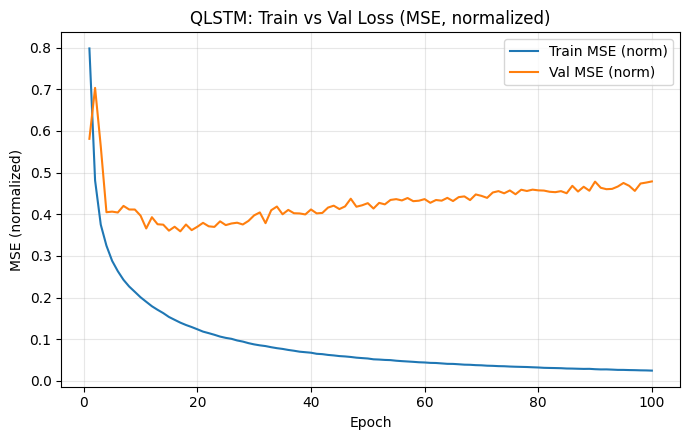

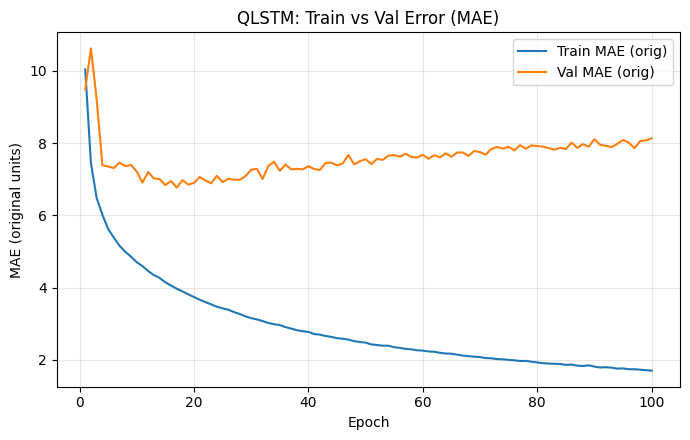

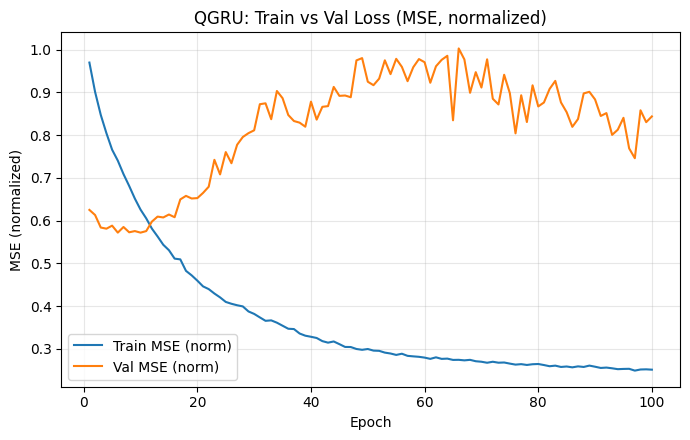

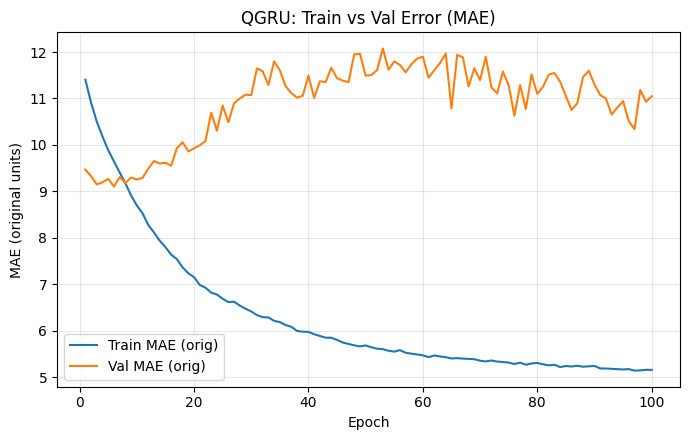

Saved figures to:
  runs/20250828-110348_QLSTM\qlstm_loss_mse.png
  runs/20250828-110348_QLSTM\qlstm__loss_mae.png
  runs/20250828-091108_QGRU\qgru_loss_mse.png
  runs/20250828-091108_QGRU\qgru__loss_mae.png


In [ ]:
# plot_losses.py
import os
import pandas as pd
import matplotlib.pyplot as plt

# GRU_DIR = gru_run_dir
QGRU_DIR = qlstm_run_dir


def plot_for_run(run_dir: str, model_name: str):
    csv_path = os.path.join(run_dir, "losses.csv")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Could not find {csv_path}")

    df = pd.read_csv(csv_path)
    # Clean up / enforce expected columns
    expected = ["epoch", "train_mse_norm", "train_mae_orig",
                "val_mse_norm", "val_mae_orig", "lr", "epoch_time_sec"]
    missing = [c for c in expected if c not in df.columns]
    if missing:
        raise ValueError(f"{csv_path} is missing columns: {missing}")

    # Sort by epoch just in case
    df = df.sort_values("epoch")

    # --- Plot MSE (normalized) ---
    plt.figure(figsize=(7, 4.5))
    plt.plot(df["epoch"], df["train_mse_norm"], label="Train MSE (norm)")
    plt.plot(df["epoch"], df["val_mse_norm"],   label="Val MSE (norm)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE (normalized)")
    plt.title(f"{model_name}: Train vs Val Loss (MSE, normalized)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    out_png = os.path.join(run_dir, f"{model_name.lower()}_loss_mse.png")
    plt.savefig(out_png, dpi=150)
    plt.show()

    # --- Plot MAE (original units) ---
    plt.figure(figsize=(7, 4.5))
    plt.plot(df["epoch"], df["train_mae_orig"], label="Train MAE (orig)")
    plt.plot(df["epoch"], df["val_mae_orig"],   label="Val MAE (orig)")
    plt.xlabel("Epoch")
    plt.ylabel("MAE (original units)")
    plt.title(f"{model_name}: Train vs Val Error (MAE)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    out_png = os.path.join(run_dir, f"{model_name.lower()}__loss_mae.png")
    plt.savefig(out_png, dpi=150)
    plt.show()


if __name__ == "__main__":
    # plot_for_run(GRU_DIR, "GRU")
    plot_for_run(QGRU_DIR,  "QLSTM")
    print("Saved figures to:")
    # print(" ", os.path.join(GRU_DIR, "gru_loss_mse.png"))
    # print(" ", os.path.join(GRU_DIR, "gru__loss_mae.png"))
    print(" ", os.path.join(QGRU_DIR,  "qlstm_loss_mse.png"))
    print(" ", os.path.join(QGRU_DIR,  "qlstm__loss_mae.png"))